In [54]:
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import torch.nn.functional as F

In [55]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')

# CORREÇÃO 1: Adicione .copy() aqui para garantir que o Pandas crie um novo objeto
# limpo na memória, desconectado do original.
data = data[data['total sulfur dioxide'] < 200].copy()

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# CORREÇÃO 2: Forma correta de criar a coluna booleana sem "Chained Assignment".
# Em vez de criar zeros e depois substituir, fazemos a lógica direto.
# O .astype(int) converte True para 1 e False para 0.
data['boolQuality'] = (data['quality'] > 5).astype(int)

labels = data['boolQuality']
data.drop('boolQuality', axis=1, inplace=True)
data.drop("quality", axis=1, inplace=True)

# Converter para tensores
# Dica: Verifique se você não deveria remover a coluna 'quality' original também,
# pois ela contém a resposta (data leakage). Se precisar remover, descomente abaixo:
# data.drop('quality', axis=1, inplace=True)

data_tensor = torch.tensor(data.to_numpy(), dtype=torch.float32)
labels_tensor = torch.tensor(labels.to_numpy(), dtype=torch.float32)[:, None]

X_train, X_test, y_train, y_test = train_test_split(data_tensor, labels_tensor, test_size=.2)

datasetTrain = TensorDataset(X_train, y_train)
datasetTest = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(datasetTrain, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(datasetTest, batch_size=datasetTest.tensors[0].shape[0])

In [56]:
y_train.shape

torch.Size([1277, 1])

In [57]:
class annWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.input = nn.Linear(11,16)
        
        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)
        
        self.output = nn.Linear(20,1)
        
    def forward(self, x, doBN):
        
        x = F.relu(self.input(x))
        
        
        if doBN:
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)
            
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)
            
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            
        return self.output(x)
            

In [58]:

def trainModel(ann, lossfun, optimizer, doBN=True):
    trainAcc = []
    testAcc = []
    losses = []
    
    for epoch in range(1000):
        batchAcc = []
        batchLoss = []
        ann.train()
        for X,y in train_loader:
            y_pred = ann(X, doBN)
            
            loss = lossfun(y_pred,y)
            
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*(torch.mean(((y_pred>0) == y).float())).item())
            batchLoss.append(loss.item())
            
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        ann.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            y_pred = ann(X, doBN)
            
        testAcc.append(100*(torch.mean((((y_pred>0) == y).float()))).item())
        
    return trainAcc, testAcc, losses

In [59]:
winenet = annWithBatchNorm()
optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)
lossfun = nn.BCEWithLogitsLoss()
trainNo, testNo, lossesNo = trainModel(winenet, lossfun, optimizer ,False)

winenet = annWithBatchNorm()
optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)
lossfun = nn.BCEWithLogitsLoss()
trainWith, testWith, lossesWith = trainModel(winenet, lossfun, optimizer ,True)

Text(0.5, 1.0, 'Test')

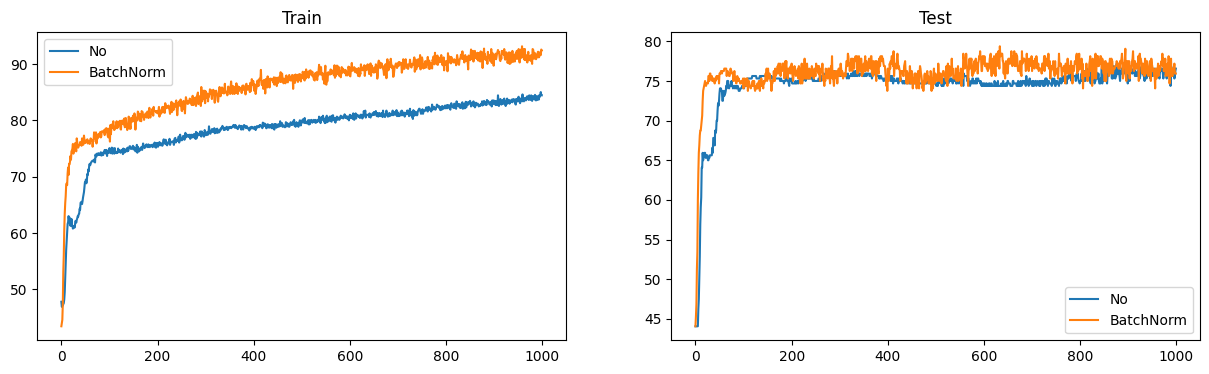

In [60]:
fig, ax = plt.subplots(1,2, figsize=(15,4))


ax[0].plot(np.array(trainNo).T)
ax[0].plot(np.array(trainWith).T)
ax[0].legend("No BatchNorm".split())
ax[0].set_title("Train")



ax[1].plot(np.array(testNo).T)
ax[1].plot(np.array(testWith).T)
ax[1].legend("No BatchNorm".split())
ax[1].set_title("Test")


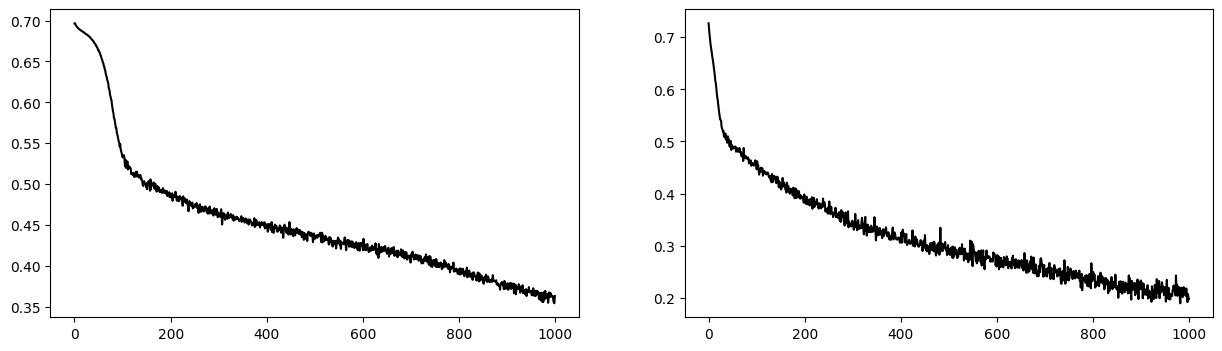

In [61]:
fig, ax = plt.subplots(1,2, figsize=(15,4))


ax[0].plot(np.array(lossesNo).T, "k")

ax[1].plot(np.array(lossesWith).T, "k")